In [1]:
import time
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import cma
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import networkx as nx
from docplex.mp.model import Model
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2, QAOAAnsatz, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import InstructionProperties, PassManager, StagedPassManager
from qiskit.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.visualization import plot_circuit_layout, plot_histogram
from qiskit.visualization.timeline import IQXStandard, draw
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeGuadalupeV2, FakeManilaV2
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.translators import from_docplex_mp
from rustworkx.visualization import mpl_draw as draw_graph
from scipy.optimize import minimize
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from sympy import Matrix, cos, exp, nsimplify, simplify, sin, symbols, pi, diff, lambdify

seed = 42

In [2]:
backend_options = {
    "precision": "single",
    "max_parallel_threads": 12,
    "max_parallel_experiments": 0,
    "max_parallel_shots": 0,
    "fusion_enable": True,
    "fusion_threshold": 14,
    "fusion_max_qubit": 4,
    "matrix_product_state_max_bond_dimension": 64,
    "matrix_product_state_truncation_threshold": 1e-6,
    "mps_sample_measure_algorithm": "mps_apply_measure",
    "mps_parallel_threshold": 12,
    "mps_omp_threads": 12,
    "mps_lapack": False,
}

aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
aer_sim.set_max_qubits(100)

estimator = Estimator(mode=aer_sim)

In [3]:
# This graph is unweighted
N = 6 # number of nodes
n_qubits = N # number of qubits
d = 3 # degree of regular graph
s = 102 # seed val
graph = rx.networkx_converter(nx.random_regular_graph(d, N, s))

# gname = f"N_{N}_{d}_reg_seed_{s}"
# graph = rx.networkx_converter(nx.read_adjlist(f"data/graphs/{gname}.txt", nodetype=int))

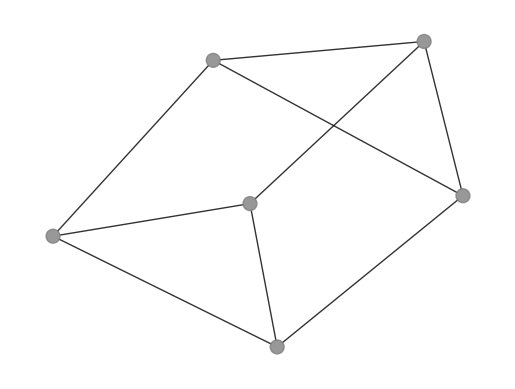

In [4]:
pos, default_axes = rx.spring_layout(graph), plt.axes(frameon=True)
rx.visualization.mpl_draw(graph, node_color=["tab:grey"] * N, node_size=100, alpha=0.8, pos=pos)

In [5]:
# classical solution
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(graph.num_nodes())}

objective = -mdl.sum(
     x[i] * (1 - x[j])
    + x[j] * (1 - x[i])
    for i, j in graph.edge_list()
)
mdl.minimize(objective)
qp = from_docplex_mp(mdl)
print(qp.prettyprint())

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_4 + 2*x_0*x_5 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_3
  + 2*x_2*x_5 + 2*x_3*x_4 + 2*x_4*x_5 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [6]:
gurobi_result = GurobiOptimizer().solve(qp)
print(gurobi_result.prettyprint())

Restricted license - for non-production use only - expires 2026-11-23
objective function value: -7.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0
status: SUCCESS


In [17]:
cost_hamiltonian, offset = qp.to_ising()

In [8]:
# edges = list(graph.edge_list())
# next_edges = []
# for i in range(N):
#     nbrs_i = graph.neighbors(i)
#     for j in nbrs_i:
#         if i < j:
#             nbrs_j = graph.neighbors(j)
#             for k in nbrs_j:
#                 if j < k:
#                     next_edges.append([i, j, k])

# next_edges = sorted(next_edges, key=lambda x: (x[0], x[1], x[2]))

In [9]:
def alpha1(h_x, h_z, J, h_b, lambda_val):
#     # Calculate A, B, C, and D
    
#     # A term
#     A = 4 * sum([(h_x[i] * h_z[i])**2 for i in range(len(h_x))]) + \
#         4 * sum([(h_x[i]**2) * J[i][j]**2 for i, j in edges])
    
#     # B term
#     B = 16 * sum([h_x[i]**4 * (h_z[i])**2 for i in range(len(h_x))]) + \
#         48 * sum([(h_x[i] * h_x[j])**2 * J[i][j]**2 for i, j in edges]) + \
#         16 * sum([(h_x[i]**4) * J[i][j]**2 for i, j in edges]) + \
#         16 * sum([J[i][j]**2 * (h_x[i] * h_b[i])**2 for i, j in edges]) + \
#         16 * sum([h_b[i] * h_x[i] * h_z[i]**2 for i in range(len(h_x))])

#     # C term
#     C = 96 * sum([h_x[i]**2 * h_z[i] * J[i][j]**2 for i, j in edges]) + \
#         32 * sum([h_b[i] * h_x[i]**2 * (h_z[i])**3 for i in range(len(h_x))])

#     # D term
#     D = 96 * sum([J[i][j]**2 * J[i][k]**2 * h_x[i]**2 for i, j, k in next_edges]) + \
#         96 * sum([J[i][j]**4 * h_x[i]**2 for i in range(len(h_x)) for i, j in edges])

#     # Now calculate alpha1(λ)
#     numerator = -A
#     denominator = B * (1 - lambda_val)**2 + C * lambda_val * (1 - lambda_val) + D * lambda_val**2
    
#     alpha1 = numerator / denominator
#     return alpha1

In [14]:
ntrot = 10
dt = 0.05
T = ntrot * dt

theta = symbols("θ", real=True)

lmbd_fn = sin( (pi/2) * sin( (pi/2) * (theta/T) )**2)**2
lmbd_prime = lambdify(theta, diff(lmbd_fn))

In [15]:
# observables
obs = []
for i in range(n_qubits):
    pstr = ['I'] * n_qubits
    pstr[i] = 'Z'
    obs.append(SparsePauliOp(''.join(pstr), 1.0))

In [10]:
# X = SparsePauliOp("X")
# Y = SparsePauliOp("Y")
# Z = SparsePauliOp("Z")
# I = SparsePauliOp("I")
# YZ = Y^Z
# ZY = Z^Y
                  
hb = np.zeros(n_qubits)  # Initialize bias field
hx = -np.ones(n_qubits)
# hz = np.zeros(n_qubits)
# J = np.ones((n_qubits, n_qubits)) * 0.5

for iteration in range(2):
    print(f"Iteration {iteration+1}")
    
    # Create the circuit for one iteration
    circuit = QuantumCircuit(n_qubits)
    init_angles = np.arctan2(hx , hb + np.sqrt(hb**2 + hx**2))

    for i in range(n_qubits):
        circuit.ry(init_angles[i], i)

    for k in range(1, ntrot + 1):
        val = lmbd_prime(k * dt)
        alpha_val = alpha1(hx, hz, J, hb, val)
    #     angle = -4 * dt * val * alpha_val
    #     if not np.allclose(angle, 0):
    #         for i, j in edges:
    #             circuit.append(PauliEvolutionGate(YZ, time= angle * J[i, j]), [i, j])
    #             circuit.append(PauliEvolutionGate(ZY, time= angle * J[i, j]), [i, j])
                
    # pm = generate_preset_pass_manager(
    #     backend=aer_sim, optimization_level=3, seed_transpiler=seed
    # )
    # isa_qc = pm.run(circuit)
    
    # if iteration == 0:
    #     display(isa_qc.draw('mpl'))

    # result = estimator.run([(isa_qc, obs)]).result()
    # hb = -np.array(result[0].data.evs)
    # print(hb)

    # # energy estimaton
    # result = estimator.run([(isa_qc, cost_hamiltonian)]).result()
    # print(f"Energy: {result[0].data.evs :.4f}")
    # print('-'*50)
    print(circuit)

Iteration 1
     ┌──────────┐
q_0: ┤ Ry(-π/4) ├
     ├──────────┤
q_1: ┤ Ry(-π/4) ├
     ├──────────┤
q_2: ┤ Ry(-π/4) ├
     ├──────────┤
q_3: ┤ Ry(-π/4) ├
     ├──────────┤
q_4: ┤ Ry(-π/4) ├
     ├──────────┤
q_5: ┤ Ry(-π/4) ├
     └──────────┘
Iteration 2
     ┌──────────┐
q_0: ┤ Ry(-π/4) ├
     ├──────────┤
q_1: ┤ Ry(-π/4) ├
     ├──────────┤
q_2: ┤ Ry(-π/4) ├
     ├──────────┤
q_3: ┤ Ry(-π/4) ├
     ├──────────┤
q_4: ┤ Ry(-π/4) ├
     ├──────────┤
q_5: ┤ Ry(-π/4) ├
     └──────────┘


In [ ]:
esimator.run(())